In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset, SubsetRandomSampler
import pandas as pd
from skimage import io, transform
import os
from matplotlib import pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.models import resnet34, ResNet34_Weights, resnet18, ResNet18_Weights
from torchvision.datasets import GTSRB
import numpy as np
import time
from matplotlib import pyplot as plt
from google.colab import drive
from torch.utils.data import ConcatDataset, WeightedRandomSampler
import cv2
import copy
import PIL
from PIL import Image
import sklearn
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score, accuracy_score, f1_score, confusion_matrix
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')


In [4]:
def evaluate(model, dataloader):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predicted = predicted.cpu()
            labels = labels.cpu()
            true_labels.extend(labels.tolist())
            predicted_labels.extend(predicted.tolist())

    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    return accuracy,  f1

In [27]:
def train_model(model, dataloaders, criterion,  optimizer, num_epochs=25, is_inception=False, return_best = False):
    since = time.time()

    acc_history = {"train":[], "val":[]}
    loss_history = {"train":[], "val":[]}
    f1_history = {"train":[], "val":[]}

    best_metric = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            y_true = []
            y_pred = []
  
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.cuda()
                labels = labels.cuda()        
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):

                    if is_inception and phase == 'train':

                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs.float())
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    y_true.extend(labels.tolist())
                    y_pred.extend(preds.tolist())

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                running_loss += loss.item()
                running_corrects += torch.sum(labels == preds).item()
                
            epoch_loss = running_loss / len(dataloaders[phase])
            acc = running_corrects / len(dataloaders[phase].dataset)
            f1 = f1_score(y_true, y_pred, average='weighted')
            acc_history[phase].append(acc)
            loss_history[phase].append(epoch_loss)
            f1_history[phase].append(f1)
            

            print('{} Loss: {} Acc: {} f-sc: {}'.format(phase, epoch_loss, acc, f1))

            # deep copy the model
            if phase == 'val' and f1 > best_metric:
                best_metric = f1
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val f1: {:4f}'.format(best_metric))

    # load best model weights
    if return_best:
          model.load_state_dict(best_model_wts)
    return (acc_history, loss_history, f1_history)

In [6]:
def show_images(n):
  def inner(image_tensors):
      fig, axes = plt.subplots(nrows=5, ncols=n, figsize=(10, 4))
      for i, ax in enumerate(axes.flat):
        ax.imshow(image_tensors[i].numpy().transpose(1, 2, 0))
        ax.axis('off')
      plt.tight_layout()
      plt.show()
  return inner

In [7]:
def explore_dataset(dataset, n_images):
  #will show 5*n images
  random_indexes = np.random.randint(0, len(dataset)-1, n_images*5)
  images = []
  show = show_images(n_images)
  for i in random_indexes:
    img, cls = dataset[i]
    images.append(img)
  show(images)
 


In [ ]:
# class CLAHE():
#   def __init__(self, clipLimit=2.5, tileGridSize=(4, 4)):
#     self.clipLimit = clipLimit
#     self.tileGridSize = tileGridSize
  
#   def __call__(self, image):
#     img_array = np.array(image)
#     if len(img_array.shape) == 3:
#         # apply CLAHE to each channel separately
#         clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
#         channels = []
#         for i in range(img_array.shape[2]):
#             channel = img_array[:,:,i]
#             channel = clahe.apply(channel)
#             channels.append(channel)
#         img_array = np.stack(channels, axis=2)
#     img = Image.fromarray(img_array)
#     return img


In [8]:
def find_initial_lr(dataloader, model_, criterion):
  model = copy.deepcopy(model_)
  lr_list = np.logspace(-5, stop = 0, num = len(dataloader))
  losses = []
  model.train()
  with torch.set_grad_enabled(True):
    for batch, (X, y) in enumerate(dataloader):
      X = X.cuda()
      y = y.cuda()
      outputs = model(X.float())
      loss = criterion(outputs, y)
      optimizer = torch.optim.AdamW(model.parameters(), lr=lr_list[batch])
      losses.append(loss.item())
      loss.backward()
      optimizer.step()
  best_ind = np.asarray(losses).argmin()
  best_lr = lr_list[best_ind]
  plt.plot(lr_list, losses)
  plt.xlabel('Learning Rates')
  plt.xscale('log')
  plt.ylabel('Losses')
  plt.axvline(x=best_lr, color='r', linestyle='--')
  return best_lr


In [9]:
def show_histories(histories):

  acc_hist, loss_hist, f1_hist = histories
  train_acc, val_acc = acc_hist["train"], acc_hist["val"]
  train_loss, val_loss = loss_hist["train"], loss_hist["val"]
  train_f1, val_f1 = f1_hist["train"], f1_hist["val"]

  fig, axs = plt.subplots(3, 1, figsize=(8, 12))
  

  axs[0].plot(train_acc, label='Train Accuracy')
  axs[0].plot(val_acc, label='Val Accuracy')
  axs[0].legend()
  axs[0].set_title('Accuracy History')
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Accuracy')


  axs[1].plot(train_loss, label='Train Loss')
  axs[1].plot(val_loss, label='Val Loss')
  axs[1].legend()
  axs[1].set_title('Loss History')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Loss')


  axs[2].plot(train_f1, label='Train F1 Score')
  axs[2].plot(val_f1, label='Val F1 Score')
  axs[2].legend()
  axs[2].set_title('F1 Score History')
  axs[2].set_xlabel('Epoch')
  axs[2].set_ylabel('F1 Score')

  plt.tight_layout()
  plt.show()

In [10]:
def test(model, dataset, num_images=20):
  model.eval()
  image_indices = np.random.choice(range(len(dataset)), size=num_images, replace=False)
  for idx in image_indices:
    # Get the image and its corresponding label
    image, label = dataset[idx]
    image = image.unsqueeze(0)  # Add a batch dimension
    image = image.cuda()

    # Make a prediction
    with torch.no_grad():
        output = model(image)
        predicted_class = torch.argmax(output).cpu().item()

    # Convert the tensor image to a NumPy array for visualization
    image = image.cpu()
    image = image.squeeze(0).permute(1, 2, 0).numpy()
    image = np.clip(image, 0, 1)

    # Get the true class label
    true_class = label

    # Display the image, true class, and predicted class
    plt.imshow(image)
    plt.title(f"True class: {true_class}\nPredicted class: {predicted_class}")
    plt.axis("off")
    plt.show()

In [11]:
def conf_matr(model, DataLoader):
  model.eval()
  true_labels = []
  predicted_labels = []
  with torch.no_grad():
    for inputs_val, labels_val in DataLoader: 
        inputs_val = inputs_val.cuda()
        labels_val = labels_val.cuda()

        outputs_val = model(inputs_val)
        _, predicted_val = torch.max(outputs_val.data, 1)

        labels_val = labels_val.cpu().numpy()
        predicted_val = predicted_val.cpu().numpy()

        true_labels.extend(labels_val)
        predicted_labels.extend(predicted_val)


  true_labels = np.array(true_labels)
  predicted_labels = np.array(predicted_labels)

  confusion_mat = confusion_matrix(true_labels, predicted_labels)

  fig, ax = plt.subplots(figsize=(12, 10))

  sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", ax=ax)


  ax.set_xlabel("Predicted Labels")
  ax.set_ylabel("True Labels")
  ax.set_title("Confusion Matrix")





In [12]:
augment_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((128, 128)),
                                                    torchvision.transforms.RandomRotation(20),
                                                    transforms.ColorJitter(brightness=(0.2, 1.8)),
                                                    torchvision.transforms.ToTensor()])
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((128, 128)),  torchvision.transforms.ToTensor()])

In [13]:
RawDataset = GTSRB(root="./", split="train", download=True, transform=transform)
TestDataset = GTSRB(root="./", split="test", download=True, transform=transform)

100%|██████████| 187490228/187490228 [00:07<00:00, 26655631.88it/s]


Extracting gtsrb/GTSRB-Training_fixed.zip to gtsrb


100%|██████████| 88978620/88978620 [00:03<00:00, 23330263.82it/s]


Extracting gtsrb/GTSRB_Final_Test_Images.zip to gtsrb


100%|██████████| 99620/99620 [00:00<00:00, 499868.48it/s]

Extracting gtsrb/GTSRB_Final_Test_GT.zip to gtsrb


In [14]:
test_size = int(0.5 * len(TestDataset))
val_size = len(TestDataset) - test_size
TestData, ValData = random_split(TestDataset, [test_size, val_size])

In [15]:
AugmentedTrain = GTSRB(root="./", split="test", download=True, transform=augment_transform)
TrainDataset = ConcatDataset([RawDataset, AugmentedTrain])

In [ ]:
explore_dataset(TestDataset, 5)

In [ ]:
explore_dataset(AugmentedTrain, 5)

In [18]:
labels = [res[1] for res in TrainDataset]
class_count = np.bincount(labels)
weights = 1 / np.array([class_count[y] for y in labels])
sampler = WeightedRandomSampler(weights, len(TrainDataset))

In [19]:
batch_size = 256
TrainLoader = DataLoader(TrainDataset, batch_size = batch_size, sampler=sampler)
TestLoader = DataLoader(TestDataset, batch_size = batch_size)
ValLoader = DataLoader(ValData, batch_size=batch_size)
DataLoaders = {"train":TrainLoader, "val":ValLoader}

In [ ]:
model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
for param in model.parameters():
  param.requires_grad = False
model.fc = nn.Linear(512,43)
model.cuda()

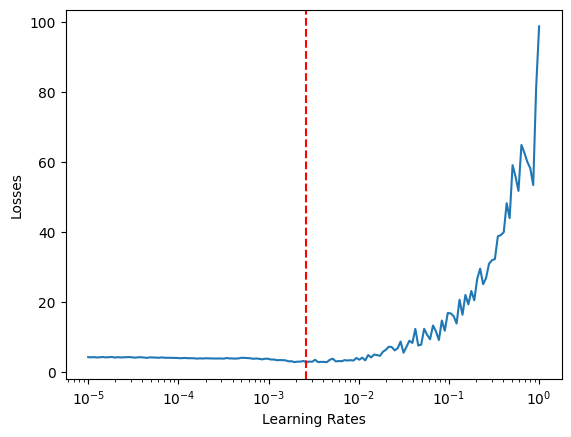

In [21]:
best_in_lr1 = find_initial_lr(TrainLoader, model, nn.CrossEntropyLoss())

In [28]:
optimizer = torch.optim.AdamW(model.parameters(), lr=best_in_lr1)
criterion = nn.CrossEntropyLoss()
histories1 = train_model(model, DataLoaders, criterion, optimizer, num_epochs=1)

Epoch 0/0
----------
train Loss: 1.4243731042007348 Acc: 0.6231983702571938 f-sc: 0.6201262374744276
val Loss: 1.1043338108062744 Acc: 0.6657165479018211 f-sc: 0.6656810249935575

Training complete in 1m 5s
Best val f1: 0.665681


In [29]:
for param in model.parameters():
  param.requires_grad = True

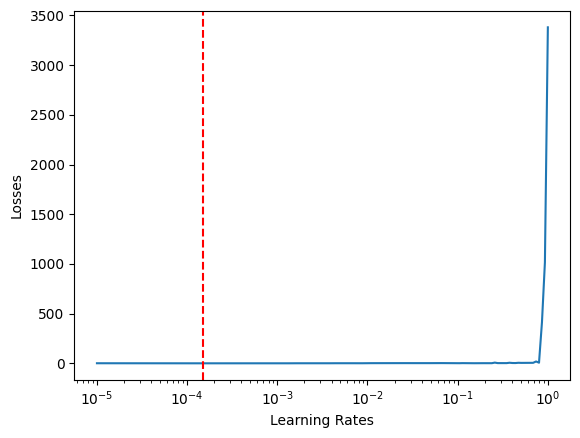

In [30]:
best_in_lr2 = find_initial_lr(TrainLoader, model, nn.CrossEntropyLoss())
optimizer = torch.optim.AdamW(model.parameters(), lr=best_in_lr2)

In [31]:
histories2 = train_model(model, DataLoaders, criterion, optimizer, num_epochs=6)

Epoch 0/5
----------
train Loss: 0.08421275062734479 Acc: 0.9751209574738986 f-sc: 0.9751158563337404
val Loss: 0.023924561478197576 Acc: 0.9920823436262867 f-sc: 0.9919844991797963

Epoch 1/5
----------
train Loss: 0.011361050441431776 Acc: 0.9964094728800611 f-sc: 0.9964080405088629
val Loss: 0.011146156606264413 Acc: 0.996991290577989 f-sc: 0.9970052504709674

Epoch 2/5
----------
train Loss: 0.009474618810564642 Acc: 0.9970715558950853 f-sc: 0.9970716731272433
val Loss: 0.00750816760584712 Acc: 0.9977830562153602 f-sc: 0.9978081239951705

Epoch 3/5
----------
train Loss: 0.004165463833960058 Acc: 0.9988286223580342 f-sc: 0.9988284034345345
val Loss: 0.050942593179643156 Acc: 0.9874901029295329 f-sc: 0.987546048733988

Epoch 4/5
----------
train Loss: 0.005539285018425904 Acc: 0.9986249045072575 f-sc: 0.9986249173450191
val Loss: 0.0010361358225054573 Acc: 0.9996832937450515 f-sc: 0.9996832894844643

Epoch 5/5
----------
train Loss: 0.0031434846820851013 Acc: 0.9993124522536287 f-sc

In [32]:
acc, f1 = evaluate(model, TrainLoader)
print(acc, f1)


0.9979628214922333 0.997951723744996


In [33]:
acc, f1 = evaluate(model, ValLoader)
print(acc, f1)

0.9947743467933492 0.9947187618162364


In [34]:
acc, f1 = evaluate(model, TestLoader)
print(acc, f1)

0.9953285827395091 0.99529754190195


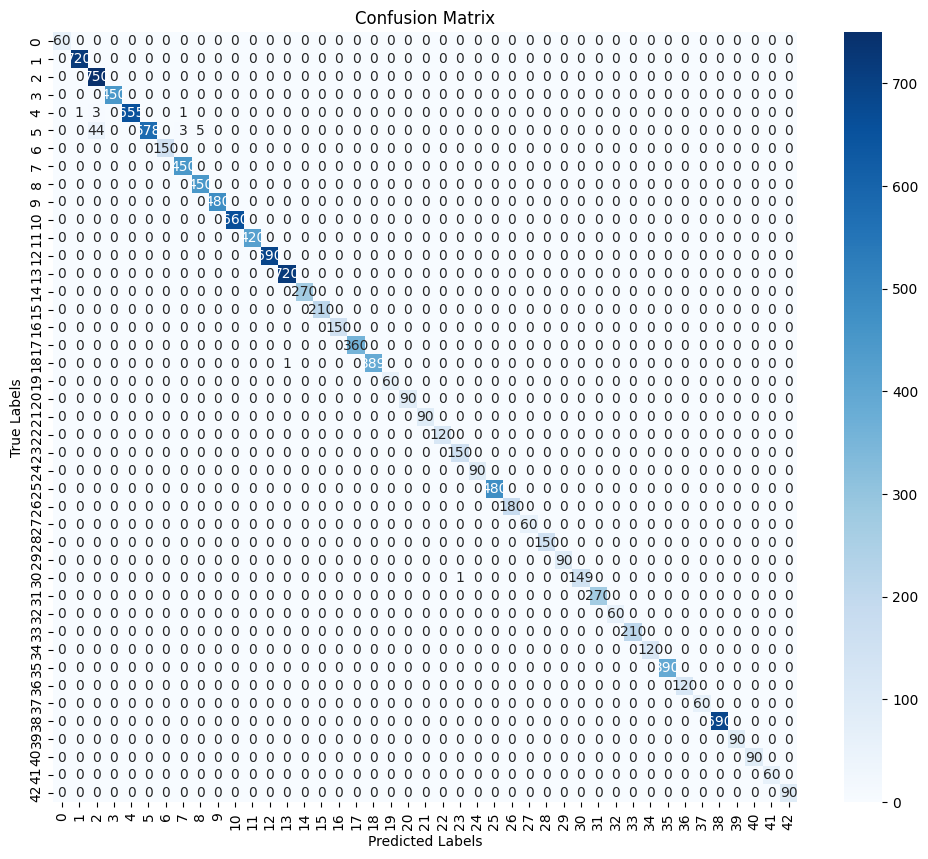

In [35]:
conf_matr(model, TestLoader)

In [38]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
model2 = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
for param in model2.parameters():
  param.requires_grad = False
model2.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(512,43)
    )
model2.cuda()

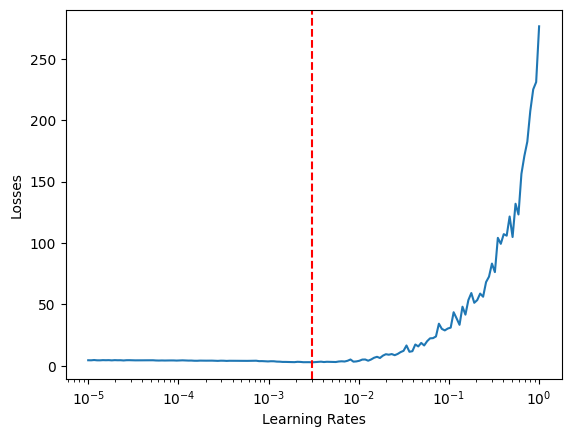

In [46]:
best_in_lr3 = find_initial_lr(TrainLoader, model2, nn.CrossEntropyLoss())

In [47]:
optimizer = torch.optim.AdamW(model2.parameters(), lr=best_in_lr3)
criterion = nn.CrossEntropyLoss()
histories3 = train_model(model2, DataLoaders, criterion, optimizer, num_epochs=1)

Epoch 0/0
----------
train Loss: 1.8563424944877625 Acc: 0.4805449452508276 f-sc: 0.47637619964320027
val Loss: 1.174472861289978 Acc: 0.6547901821060966 f-sc: 0.6541671143476153

Training complete in 1m 6s
Best val f1: 0.654167


In [48]:
for param in model2.parameters():
  param.requires_grad = True

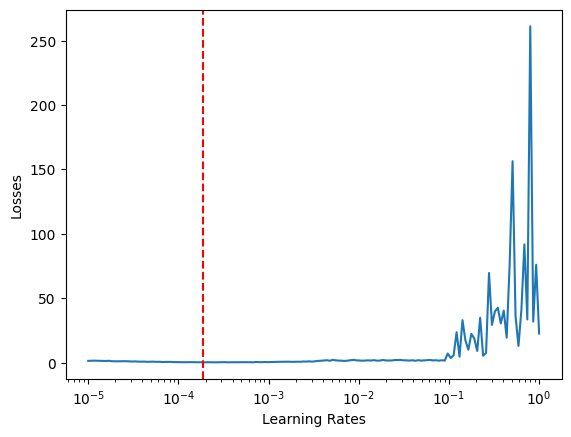

In [50]:
best_in_lr4 = find_initial_lr(TrainLoader, model2, nn.CrossEntropyLoss())

In [52]:
optimizer = torch.optim.AdamW(model2.parameters(), lr=best_in_lr4)
criterion = nn.CrossEntropyLoss()
histories4 = train_model(model2, DataLoaders, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.0813167217299463 Acc: 0.9738986503692386 f-sc: 0.9738753992790523
val Loss: 0.0351359698921442 Acc: 0.9876484560570071 f-sc: 0.987746718953587

Epoch 1/9
----------
train Loss: 0.015668708159793893 Acc: 0.9952890247007894 f-sc: 0.995288736690512
val Loss: 0.008336722422391175 Acc: 0.997624703087886 f-sc: 0.9976237169512305

Epoch 2/9
----------
train Loss: 0.008716313607609745 Acc: 0.9975044563279858 f-sc: 0.997504415752422
val Loss: 0.002185516753816046 Acc: 0.9995249406175772 f-sc: 0.9995246637224848

Epoch 3/9
----------
train Loss: 0.007867756484502733 Acc: 0.9980646804176216 f-sc: 0.9980648157728772
val Loss: 0.003940263068070635 Acc: 0.9985748218527316 f-sc: 0.9985756779149804

Epoch 4/9
----------
train Loss: 0.008331910168730151 Acc: 0.997886427298192 f-sc: 0.9978867096605597
val Loss: 0.05376684382557869 Acc: 0.9835312747426762 f-sc: 0.9833065236389352

Epoch 5/9
----------
train Loss: 0.0035671924331411417 Acc: 0.9991596638655462 f-sc: 0.999

In [55]:
acc, f1 = evaluate(model2, TrainLoader)
print(acc, f1)

0.9992869875222816 0.9992869879914388


In [56]:
acc, f1 = evaluate(model2, ValLoader)
print(acc, f1)

0.9993665874901029 0.9993665773191764


In [58]:
acc, f1 = evaluate(model2, TestLoader)
print(acc, f1)

0.9995249406175772 0.9995251010688108


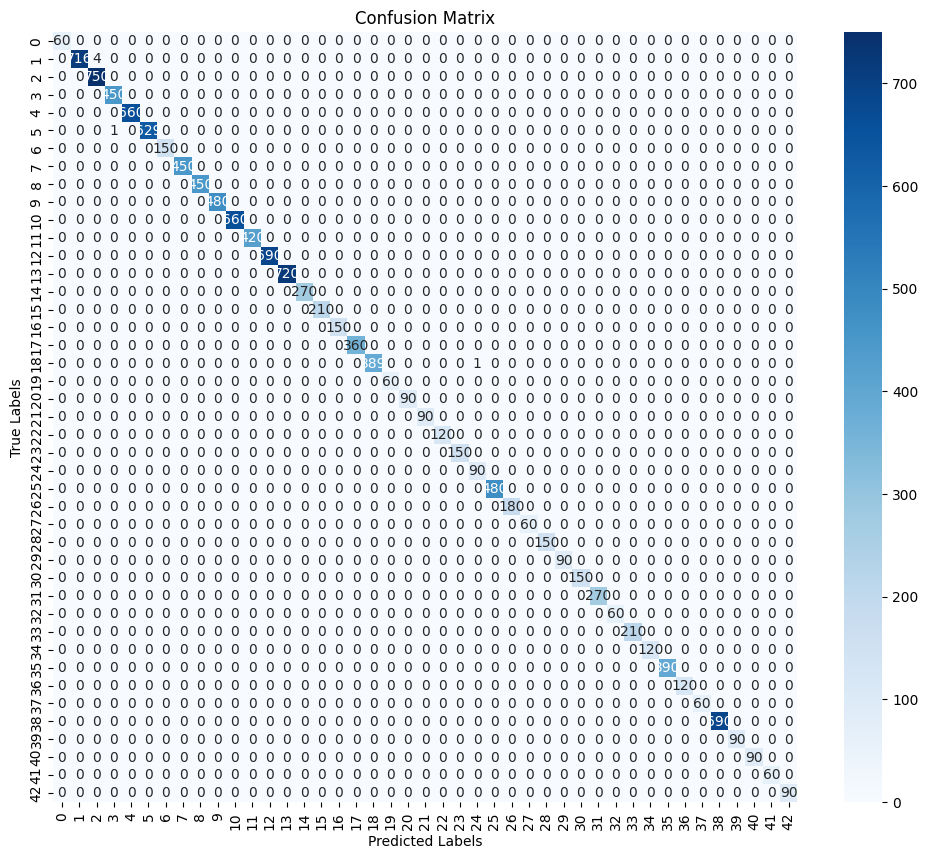

In [59]:
conf_matr(model2, TestLoader)

In [61]:
torch.save(model2.state_dict(), "model2.pth")